In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_approx import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor
from torch import autograd
torch.manual_seed(4)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

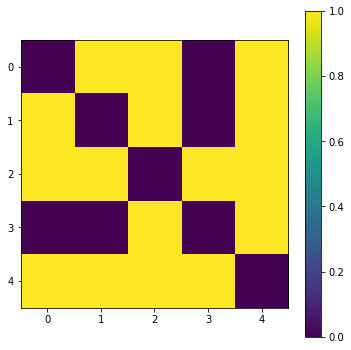

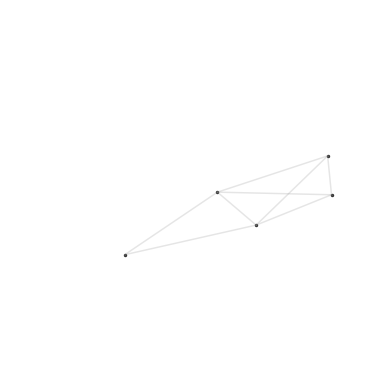

In [5]:
N = 5
R = torch.tensor([5.0]).double()
alpha = .7
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [6]:
r_loc_init = logit(noise_r(r, R, rel_var=0.05)/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = torch.cat((polar2cart(1, noise_phi(theta, 0.02)),  torch.zeros([N,1]).double()), dim=-1)
phi_loc_init.shape

torch.Size([5, 3])

In [7]:
r_loc_init

tensor([ 1.8354,  1.9024, -0.4989,  0.5558, -1.4038], dtype=torch.float64)

In [8]:
Radius(r_loc_init, r_scale_init.exp(), R.expand([N])).mean

tensor([4.3120, 4.3508, 1.8890, 3.1774, 0.9861], dtype=torch.float64)

In [9]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [10]:
T_init

tensor([1.0986, 2.3026])

In [11]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N**2, shuffle=True, num_workers=0)
vi = VI_HRG(N,10, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':None, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [12]:
with autograd.detect_anomaly():
    vi.train(dataloader, lrs=0.1, debug=True, epochs=50)

>>>>>>>>>>>> Start training...
-D_kl(R)    >> tensor(-7.4639, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.8525, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.8176, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-125.9165, dtype=torch.float64, grad_fn=<SumBackward0>)


../src/utils.py:126: UserWarning: cosh_dist has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:126: UserWarning: c has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


Alpha_R_ri  >> tensor(-464.0568, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-26.1030, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(32.3456, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.1105, -1.2390, -2.2518, -2.2558, -1.4602],
        [-2.9155, -2.1327, -2.4197, -2.1499, -1.4365],
        [-1.2070, -1.0870, -2.3977, -2.4808, -1.9887],
        [-0.1783, -0.7402, -1.3987, -1.1252, -1.2008],
        [-1.5099, -1.0782, -1.9039, -1.8253, -1.2105],
        [-1.4065, -1.0501, -1.7592, -1.9677, -1.2185],
        [-2.3398, -2.1897, -1.9489, -1.8145, -3.9999],
        [-0.3820, -0.9156, -4.5684, -1.3304, -1.9365],
        [-1.2018, -1.4934, -1.9370, -1.8233, -1.3179],
        [-0.3852, -0.4019, -1.4191, -1.2139, -1.1135]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
P(q_ri)     >> tensor(204.5961, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.3007, -1.1285, -1.2247, -2.9008, -3.9570],
        [-2.4147, -2.3567, -1.5290

-D_kl(R)    >> tensor(-5.5839, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.7978, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5828, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-74.2476, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-264.0706, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-17.2408, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(17.8710, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.0727, -0.1734, -1.4224, -1.3917, -1.8244],
        [-1.0268, -2.6293, -1.7299, -1.2248, -3.2870],
        [-1.5848, -2.2194, -2.4338, -1.7844, -3.0385],
        [-1.4991, -1.4684, -1.9980, -3.4239, -1.2594],
        [-1.9378, -2.2759, -2.1205, -2.0439, -1.6798],
        [-1.1244, -0.9954, -2.1763, -2.0427, -1.5459],
        [-0.9584, -0.6329, -2.1512, -4.5284, -1.3898],
        [ 0.1641,  0.1949, -1.2183, -1.5445, -0.7132],
        [-1.3757, -1.032

-D_kl(R)    >> tensor(-5.5971, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.7540, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5360, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-71.7821, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-356.0113, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-21.9563, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(26.7698, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-0.8406, -2.1552, -1.0613, -1.2930, -0.5475],
        [-1.0531, -1.6461, -1.9066, -1.4095, -2.7820],
        [-2.1520, -1.3426, -2.3542, -1.9531, -2.1098],
        [-1.3982, -1.6479, -2.3456, -2.0244, -2.8065],
        [-1.8710, -0.3270, -1.3711, -0.9141, -0.9106],
        [-1.1283, -0.9416, -1.6925, -1.9056, -1.0195],
        [-0.9201, -1.6789, -1.8756, -1.3026, -2.0436],
        [-1.2031, -3.1585, -2.3891, -1.5114, -3.9784],
        [-1.1171, -2.689

-D_kl(R)    >> tensor(-6.5231, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.5866, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5244, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-59.6747, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-183.5610, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-9.8608, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(5.6736, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-3.1173, -1.0466, -1.9875, -1.5542, -1.7948],
        [-2.7722, -2.5369, -2.3722, -2.2305, -1.8618],
        [-1.6465, -1.1006, -1.8434, -1.3255, -1.4055],
        [-1.6261, -1.5094, -1.7246, -1.8349, -1.9115],
        [-1.1579, -2.0521, -1.8683, -1.4193, -1.5538],
        [-0.4163, -0.5238, -1.2947, -0.7309, -1.5593],
        [-2.0129, -2.6498, -2.4831, -2.0113, -2.4804],
        [-1.9057, -1.4349, -2.2418, -2.9497, -1.6255],
        [-1.2298, -1.6833,

-D_kl(R)    >> tensor(-6.2363, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6127, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5273, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-65.1310, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-192.7416, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-12.0345, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(9.0763, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.0998, -1.3293, -2.4298, -1.5746, -1.5949],
        [-2.0974, -3.6211, -2.2102, -2.3247, -2.1124],
        [-1.9554, -0.5224, -1.4039, -1.4198, -1.3515],
        [-0.8009, -1.1661, -1.6830, -1.1832, -2.4377],
        [-0.9916, -1.4656, -1.3329, -1.9417, -1.8886],
        [-1.9033, -2.0400, -2.3103, -2.3693, -1.7121],
        [-1.1945, -1.2577, -1.8724, -1.5232, -1.8042],
        [-2.8941, -1.6173, -1.9776, -2.2019, -1.9030],
        [-1.7951, -4.6123

-D_kl(R)    >> tensor(-6.6315, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.5868, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5379, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-82.5042, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-262.6206, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-12.5174, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(9.7245, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.7032, -1.1056, -1.9814, -1.8869, -1.8462],
        [-1.3657, -2.0395, -2.0821, -1.9767, -2.4437],
        [-3.1338, -2.0457, -2.4680, -2.3993, -2.2776],
        [-3.6672, -3.6434, -2.5999, -3.9113, -2.8790],
        [-0.6456, -0.3574, -1.3173, -1.0382, -1.4655],
        [-1.6168, -1.6473, -2.1947, -2.9522, -2.1414],
        [-1.4205, -1.8049, -1.8083, -1.2553, -2.4579],
        [-2.0406, -1.1916, -2.9273, -2.0318, -2.5433],
        [-1.4978, -1.4448

-D_kl(R)    >> tensor(-6.4690, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6168, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5511, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-45.1636, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-196.3579, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-8.4932, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(4.8784, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.0142, -2.3777, -1.8927, -2.0529, -3.5538],
        [-2.0222, -1.7901, -1.9028, -2.2327, -2.1758],
        [-1.3047, -1.8004, -1.7510, -2.7845, -1.4965],
        [-2.0160, -2.4049, -2.0583, -1.8797, -1.4941],
        [-1.3713, -1.7455, -1.7853, -1.1506, -1.5762],
        [-2.5490, -1.7961, -2.4386, -3.8367, -1.9010],
        [-1.4582, -2.1301, -2.3043, -2.7244, -2.3923],
        [-0.9518, -1.2471, -1.0731, -0.2115, -0.8839],
        [-2.1585, -1.5391,

-D_kl(R)    >> tensor(-6.5027, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6492, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5606, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-61.1691, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-171.2237, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-8.4756, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(4.4208, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-3.9678, -1.5582, -1.7752, -1.7722, -1.6835],
        [-1.5327, -1.6478, -2.0433, -2.3291, -1.8158],
        [-1.1979, -0.6877, -2.1213, -0.9459, -2.2713],
        [-2.4733, -1.1888, -2.1933, -1.7657, -2.1953],
        [-3.0255, -1.3265, -2.4125, -1.9337, -2.5610],
        [-1.6003, -1.3823, -2.0285, -2.4809, -2.5099],
        [-3.0214, -0.9047, -1.8518, -1.5833, -1.7271],
        [-1.6733, -3.2392, -1.8351, -1.3557, -2.2757],
        [-1.9912, -1.5381,

-D_kl(R)    >> tensor(-6.7379, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6506, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5766, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-57.2631, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-156.7678, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-7.6244, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(2.6465, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-1.3767, -1.8357, -2.0607, -2.1644, -1.8740],
        [-1.5376, -1.3132, -2.3938, -1.8569, -2.1179],
        [-1.2732, -1.7874, -3.1198, -1.7117, -2.4709],
        [-1.2613, -2.9470, -2.2968, -2.3430, -2.1227],
        [-1.8253, -0.9689, -3.3643, -2.5311, -1.8264],
        [-1.0977, -0.9215, -1.8082, -1.0756, -1.7791],
        [-1.7467, -1.8542, -2.2937, -1.6328, -2.2148],
        [-3.3080, -2.9683, -1.5745, -0.9354, -1.7842],
        [-1.5664, -1.1381,

../src/utils.py:124: UserWarning: cosh_dist has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
../src/utils.py:124: UserWarning: c has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
../src/utils.py:124: UserWarning: temp1 has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))


-D_kl(R)    >> tensor(-6.4961, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6763, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5877, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-76.5493, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-209.9552, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-6.8279, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(2.6630, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-2.3062, -1.1195, -1.4603, -0.9887, -1.6716],
        [-1.7135, -2.6264, -2.2027, -1.6055, -2.4167],
        [-1.5832, -2.4147, -2.6407, -1.6719, -3.0941],
        [-1.4012, -2.1039, -2.1146, -3.6317, -2.2801],
        [-2.5724, -2.6600, -2.1930, -3.1202, -2.8948],
        [-1.8902, -2.6840, -2.1430, -1.5417, -1.8539],
        [-1.1144, -0.9099, -2.6673, -1.2270, -1.9642],
        [-2.2705, -3.8551, -2.1688, -1.8596, -2.1789],
        [-1.5150, -1.4434,

RuntimeError: Function 'PowBackward1' returned nan values in its 1th output.

In [13]:
vi.alpha_conc.exp(), vi.alpha_scale.exp()

(tensor(0.8017, dtype=torch.float64, grad_fn=<ExpBackward>),
 tensor(0.3026, dtype=torch.float64, grad_fn=<ExpBackward>))

In [14]:
alpha_conc_init.exp(), alpha_scale_init.exp()

(tensor(0.5000), tensor(0.5000))

In [15]:
vi.R_conc.exp(), vi.R_scale.exp()

(tensor(10.1540, dtype=torch.float64, grad_fn=<ExpBackward>),
 tensor(0.8774, dtype=torch.float64, grad_fn=<ExpBackward>))

In [16]:
R_mean = Gamma(vi.R_conc.exp(), vi.R_scale.exp().reciprocal()).mean.detach()

In [17]:
vi.rs_loc, vi.rs_scale.exp()

(Parameter containing:
 tensor([ 1.2968,  1.3679,  0.3714,  1.2190, -0.3822], dtype=torch.float64,
        requires_grad=True),
 tensor([1.3827, 1.4053, 1.2405, 1.3211, 1.2795], dtype=torch.float64,
        grad_fn=<ExpBackward>))

In [18]:
post_r = Radius(vi.rs_loc, vi.rs_scale.exp(), R_mean.expand([N]))

In [19]:
post_r.mean

tensor([6.9966, 7.1012, 5.2726, 6.8772, 3.6138], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [20]:
r

tensor([4.2345, 4.2333, 2.1902, 3.0441, 0.6701], dtype=torch.float64)

In [21]:
r_samp = post_r.sample([50])
post_r.log_prob(r_samp).mean(dim=0)

tensor([-1.8069, -1.6872, -2.0903, -1.8157, -2.1242], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [22]:
R_mean.log()

tensor(2.1871, dtype=torch.float64)

In [23]:
vi.phis_loc, vi.phis_scale.exp()

(Parameter containing:
 tensor([[ 0.8199,  0.0179, -0.0180],
         [ 1.5305, -0.0207, -0.0073],
         [ 0.8395, -0.0065, -0.0187],
         [ 0.0422, -0.2112,  0.1066],
         [ 0.8404, -0.0191,  0.0020]], dtype=torch.float64, requires_grad=True),
 tensor([6.9213, 9.9104, 7.8998, 0.8818, 6.5830], dtype=torch.float64,
        grad_fn=<ExpBackward>))

In [ ]:
p_hd_ = lambda d,R,T: (1.+((d-R)/(2.*T)).exp()).reciprocal()
phd = lambda d,R,T: 0.5 + 0.5*(-(d-R)/(4*T)).tanh()

In [ ]:
p_hd_(torch.tensor(-np.inf),R,T)

In [ ]:
phd(torch.tensor(5.1),R,T)

In [ ]:
torch.tensor([0.1,10.0]).log()

In [ ]:
x = torch.arange(0.,1.,.01)
plt.plot(x, torch.sigmoid(logit(x)))
plt.show()

In [ ]:
logit(torch.tensor(0.))

In [ ]:
l, n, m = 3, 4, 5
broadcast = torch.ones([l,n])

In [ ]:
torch.rand(m).expand(n,m).t()

In [ ]:
torch.arange(n).expand(m,n)

In [ ]:
torch.tensor(0.).mean()

In [ ]:
arcosh = lambda x: (torch.clamp(x, min=1.) + (torch.clamp(x, min=1.)**2 - 1).sqrt())
arcosh(torch.arange(0.,2., .1))

In [ ]:
torch.clamp(x, min=1.)

In [ ]:
np.log(5)